# DETECCIÓN DE SELLOS EN DOCUMENTOS

La detección de estos elementos fue desarrollada con ayuda de los Cognitive Services que Azure ofrece, que nos facilitan el uso de la IA, en general existen diferentes categorías, para este caso se hizo uso de uno de los servicios de Vision, Custom Vision, este es un servicio que permite personalizar modelos de visión artificial y adaptarlos a nuestro problema, en nuestro caso la detección de sellos.

REQUERIMIENTOS PARA LA EJECUCIÓN:

* Cuenta de Azure
* Un entorno virtual (Jupyter notebooks, Google Colab) para la ejecución.


La creación de una solución de detección de objetos con Custom Vision consta de tres tareas principales. En primer lugar debe usar, cargar y etiquetar imágenes, luego puede entrenar el modelo y, finalmente, debe publicar el modelo para que las aplicaciones cliente puedan usarlo con el fin de generar predicciones.

Paso 1: Instalación del servicio cognitivo de azure

In [5]:
pip install azure-cognitiveservices-vision-customvision

     |████████████████████████████████| 62 kB 337 kB/s 
     |████████████████████████████████| 85 kB 3.2 MB/s 
     |████████████████████████████████| 45 kB 2.6 MB/s 


Paso 2. Importación de librerias para el uso de Custom Vision

In [6]:
from azure.cognitiveservices.vision.customvision.training import CustomVisionTrainingClient
from azure.cognitiveservices.vision.customvision.prediction import CustomVisionPredictionClient
from azure.cognitiveservices.vision.customvision.training.models import ImageFileCreateBatch, ImageFileCreateEntry, Region
from msrest.authentication import ApiKeyCredentials
import os, time, uuid

Paso 3: Claves del servicio para utlizar la API (previamente se creo el recurso en Azure)

Para usar el modelo se necesitan la siguiente información:

-   **Id. de proyecto**: el identificador único del proyecto.
-   **Nombre del modelo**
-   **Punto de conexión de la predicción**: la dirección HTTP de los puntos de conexión.
-   **Clave de predicción**: La clave de autenticación.

In [7]:
# Replace with valid values
ENDPOINT = "https://eastus.api.cognitive.microsoft.com/"
training_key = "fec874085f8542cba8cf32f030abb76b"
prediction_key = "f8f97ce12e674c9ba661ea9bf36e4507"
prediction_resource_id = "P8cd72fef-3822-4d97-9078-90d2724cd8f7"

In [8]:
credentials = ApiKeyCredentials(in_headers={"Training-key": training_key})
trainer = CustomVisionTrainingClient(ENDPOINT, credentials)
prediction_credentials = ApiKeyCredentials(in_headers={"Prediction-key": prediction_key})
predictor = CustomVisionPredictionClient(ENDPOINT, prediction_credentials)

Paso 4: En caso de no usar directamente la plataforma que azure ofrece se puede crear un proyecto de Custom Vision con lo siguiente:

In [ ]:
'''publish_iteration_name = "detectModel"

# Find the object detection domain
obj_detection_domain = next(domain for domain in trainer.get_domains() if domain.type == "ObjectDetection" and domain.name == "General")

# Create a new project
print ("Creating project...")
# Use uuid to avoid project name collisions.
project = trainer.create_project(str(uuid.uuid4()), domain_id=obj_detection_domain.id)'''

Creating project...


Paso 5: Se crean las etiquetas

In [ ]:

'''sello_tag = trainer.create_tag(project.id, "sello")'''


Paso 6: Entrenamiento del modelo (para facilidad en la plataforma se hizo el recorte de imagenes de entrenamiento)

Antes de poder entrenar un modelo de detección de objetos, debe etiquetar las coordenadas de las clases y del cuadro de límite en un conjunto de imágenes de entrenamiento, la plataforma de cognitive services ofrece una opción para poder etiquetar.

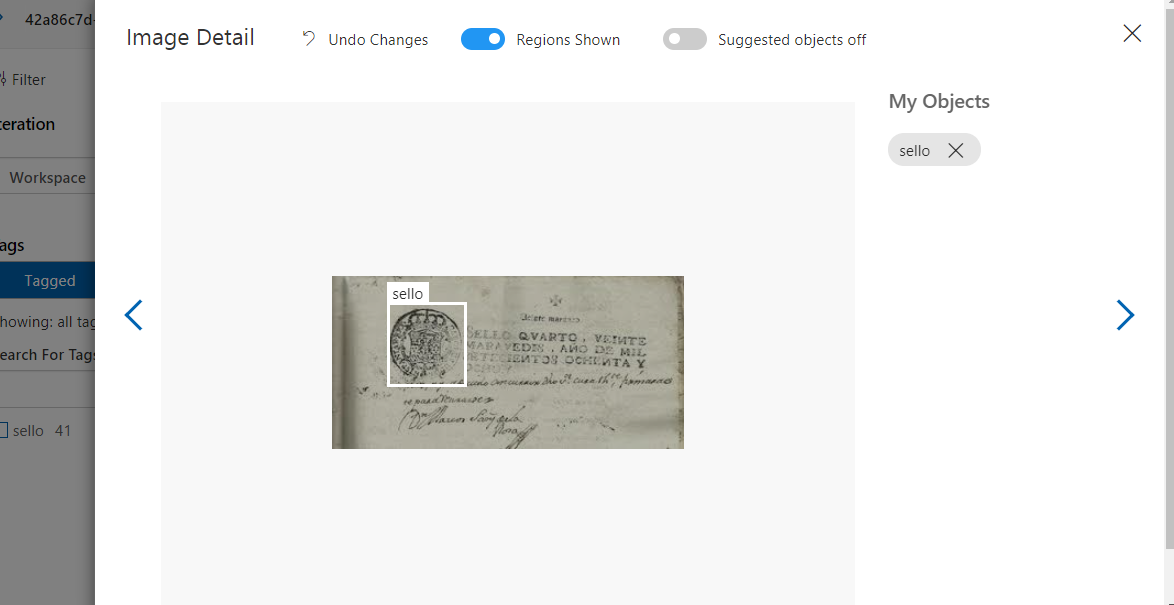

In [ ]:
'''print ("Training...")
iteration = trainer.train_project(project.id)
while (iteration.status != "Completed"):
    iteration = trainer.get_iteration(project.id, iteration.id)
    print ("Training status: " + iteration.status)
    time.sleep(1)'''

Paso 7: Conecciòn a los datos de prueba

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [40]:
indir= 'drive/MyDrive/Expedientes'
from os import scandir, getcwd
from os.path import abspath

def ls(ruta = getcwd()):
    return [abspath(arch.path) for arch in scandir(ruta) if arch.is_file()]
lista=ls(indir)
print(len(lista))

959


Paso 8: En la siguiente secciòn de código se hace una llamado de la api recorriendo cada uno de los archivos de la carpeta compartida para detectar cuando existan sellos en los documentos, se comentaron las lineas de matplotlib que permite ver de manera visual los elementos por cuestiones de memoria, en el siguiente ejemplo se manda a llamar a una cantidad menor de documentos para ver su implmentación completa.

In [ ]:
# Now there is a trained endpoint that can be used to make a prediction
from matplotlib import pyplot as plt
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import os
from os import scandir, getcwd
%matplotlib inline
# Open the sample image and get back the prediction results.


listawidth=[]
listaheight=[]
listaxmin=[]
listaymin=[]
listaxmax=[]
listaymax=[]
listanames=[]
listaetiqueta=[]
for img in lista:
    test_img_file = os.path.join ("test", img)
    test_img = Image.open(test_img_file)

    test_img_h, test_img_w, test_img_ch = np.array(test_img).shape



    with open(test_img_file, mode="rb") as test_data:
        results = predictor.detect_image("77d5d244-999b-4713-9ce2-a04ba8e410d7", "Iteration2", test_data)


    # Create a figure to display the results
    fig = plt.figure(figsize=(8, 8))
    plt.axis('off')

    # Display the image with boxes around each detected object
    draw = ImageDraw.Draw(test_img)
    lineWidth = int(np.array(test_img).shape[1]/100)

    # Display the results.    
    for prediction in results.predictions:
        if (prediction.probability*100) > 60:

            left = prediction.bounding_box.left * test_img_w 
            top = prediction.bounding_box.top * test_img_h 
            height = prediction.bounding_box.height * test_img_h
            width =  prediction.bounding_box.width * test_img_w
            points = ((left,top), (left+width,top), (left+width,top+height), (left,top+height),(left,top))
            listanames.append(os.path.basename(img))
            listawidth.append(test_img_w)
            listaheight.append(test_img_h)
            listaxmin.append(left)
            listaymin.append(top)
            listaxmax.append(left+width)
            listaymax.append(top+height)
            listaetiqueta.append(prediction.tag_name)
            #plt.annotate(prediction.tag_name + ": {0:.2f}%".format(prediction.probability * 100),(left,top))
            print(prediction.tag_name + ": {0:.2f}%".format(prediction.probability * 100))
            print(points)
            #plt.imshow(test_img)
    #print("\t" + prediction.tag_name + ": {0:.2f}% bbox.left = {1:.2f}, bbox.top = {2:.2f}, bbox.bottom = {2:.2f}, bbox.width = {3:.2f}, bbox.height = {4:.2f}".format(prediction.probability * 100, prediction.bounding_box.left, prediction.bounding_box.top, prediction.bounding_box.width, prediction.bounding_box.height))

In [42]:
datafiles = {'filename':listanames, 'width':listawidth, 'height': listaheight, 'class':listaetiqueta, 'xmin':listaxmin, 'ymin':listaymin, 'xmax':listaxmax, 'ymax':listaymax}

In [43]:
import pandas as pd 
dffiles= pd.DataFrame(datafiles)
dffiles

,filename,width,height,class,xmin,ymin,xmax,ymax
0,AGN_DFS_C.18_1_de_2_Cabrera_Arenas_Emma_pg-241...,1920,1080,sello,1478.941958,55.255118,1620.747994,213.369537
1,AGN_DFS_C.18_1_de_2_Cabrera_Arenas_Emma_pg-228...,1920,1080,sello,501.492749,30.823764,801.567936,248.879436
2,AGN_DFS_C.18_1_de_2_Cabrera_Arenas_Emma_pg-228...,1920,1080,sello,1530.046272,89.231458,1679.322893,234.506102
3,AGN_DFS_C.18_2_de_2_Cabrera_Arenas_Emma_pg-008...,1920,1080,sello,1702.643328,2.634031,1917.448128,157.215943
4,AGN_DFS_C.18_1_de_2_Cabrera_Arenas_Emma_pg-266...,1920,1080,sello,540.663014,43.118350,815.157446,244.115951
...,...,...,...,...,...,...,...,...
889,AGN_DFS_C.18_1_de_2_Cabrera_Arenas_Emma_pg-182...,1920,1080,sello,461.561741,6.938276,748.597997,212.438927
890,AGN_DFS_C.18_1_de_2_Cabrera_Arenas_Emma_pg-182...,1920,1080,sello,1451.187744,55.712488,1620.540960,202.581040
891,AGN_DFS_C.18_1_de_2_Cabrera_Arenas_Emma_pg-145...,1920,1080,sello,436.845888,29.626909,744.446246,242.797093
892,AGN_DFS_C.18_1_de_2_Cabrera_Arenas_Emma_pg-145...,1920,1080,sello,1438.299456,78.262444,1590.568589,215.014161


In [44]:
dffiles.to_csv('/content/sample_data/sellos.csv')

Se puso a prueba con los datos de evaluación y mostrando las imágenes.

In [26]:
indir= 'drive/MyDrive/Reto1'
from os import scandir, getcwd
from os.path import abspath

def ls(ruta = getcwd()):
    return [abspath(arch.path) for arch in scandir(ruta) if arch.is_file()]
lista=ls(indir)
print(len(lista))

25


sello: 86.84%
((2983.02048, 344.63638944), (3299.85436032, 344.63638944), (3299.85436032, 753.4519689599999), (2983.02048, 753.4519689599999), (2983.02048, 344.63638944))
sello: 93.68%
((519.01728, 22.2815124), (742.0462656, 22.2815124), (742.0462656, 325.621134), (519.01728, 325.621134), (519.01728, 22.2815124))
sello: 89.04%
((1644.0442752000001, 52.0251768), (1819.4796864000002, 52.0251768), (1819.4796864000002, 205.3027188), (1644.0442752000001, 205.3027188), (1644.0442752000001, 52.0251768))
sello: 92.33%
((1104.7696012800002, 2010.7271520000002), (1580.7772684800002, 2010.7271520000002), (1580.7772684800002, 2456.8383456), (1104.7696012800002, 2456.8383456), (1104.7696012800002, 2010.7271520000002))
sello: 92.23%
((1880.7570662399999, 2034.70584768), (2395.9947916799997, 2034.70584768), (2395.9947916799997, 2435.2809408000003), (1880.7570662399999, 2435.2809408000003), (1880.7570662399999, 2034.70584768))
sello: 83.60%
((2854.2720384, 2090.6811763200003), (3350.35049472, 2090.681

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


sello: 87.05%
((2495.522208, 2250.96865632), (3137.427792, 2250.96865632), (3137.427792, 2447.9975030399996), (2495.522208, 2447.9975030399996), (2495.522208, 2250.96865632))


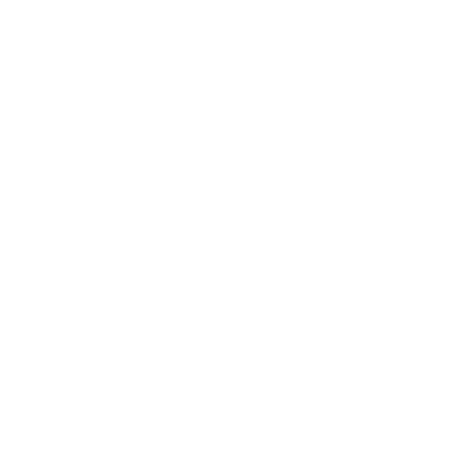

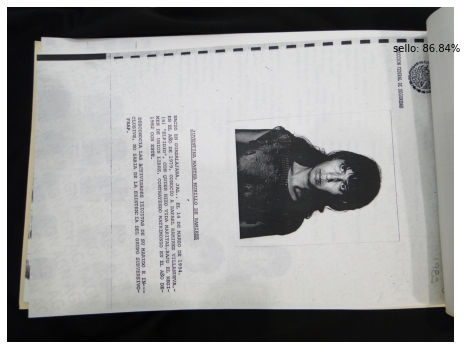

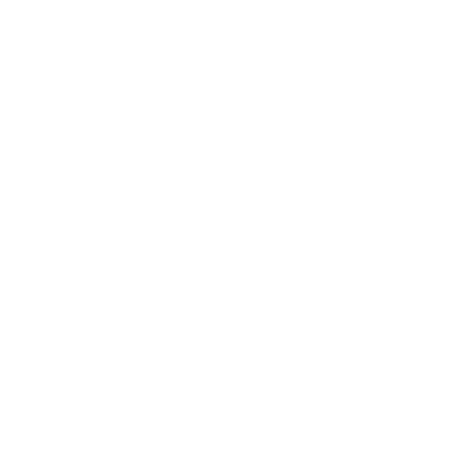

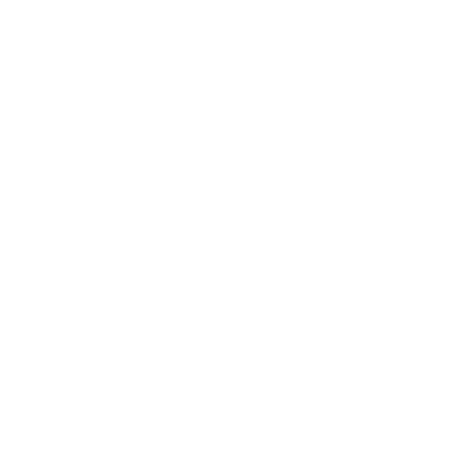

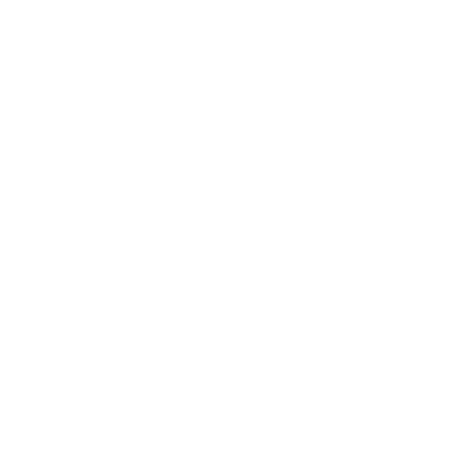

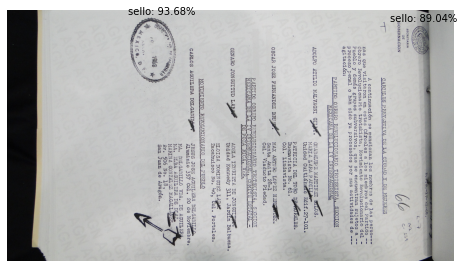

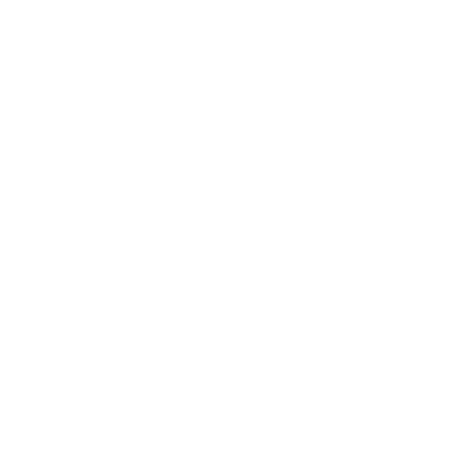

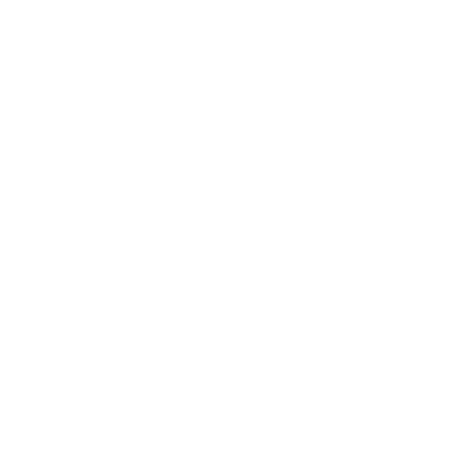

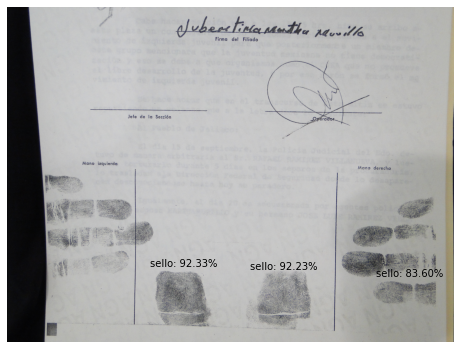

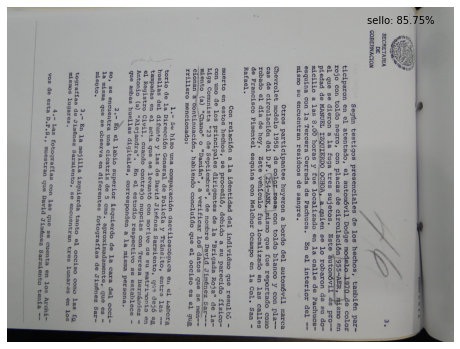

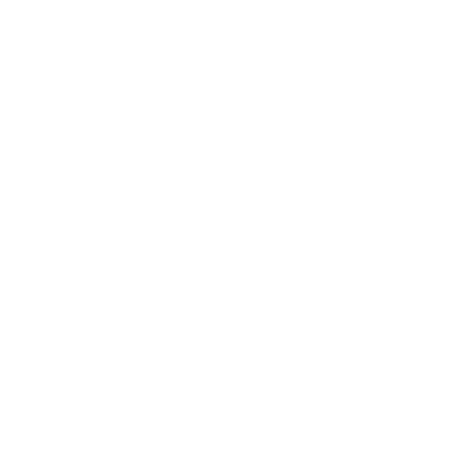

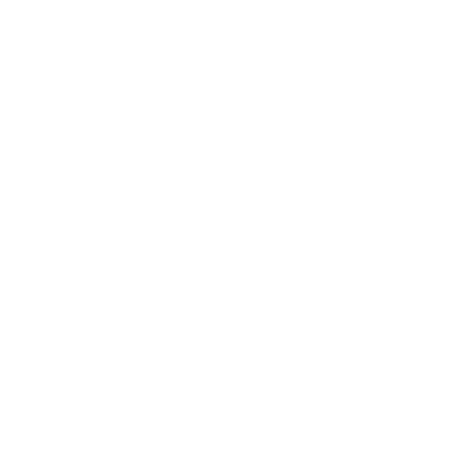

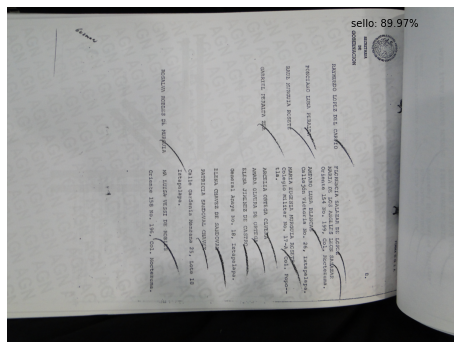

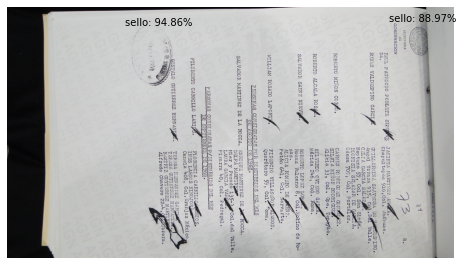

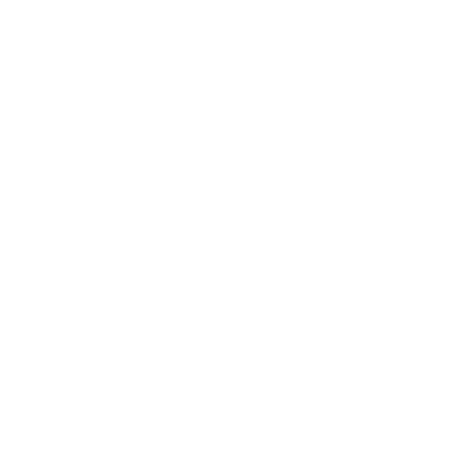

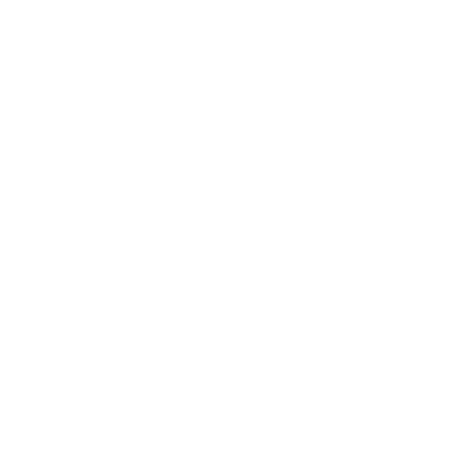

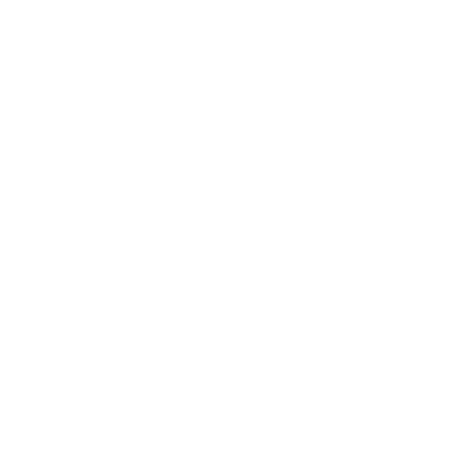

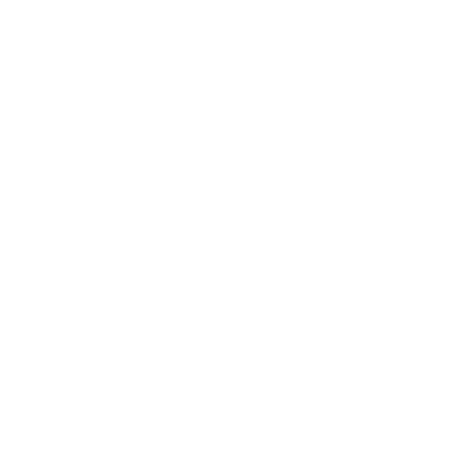

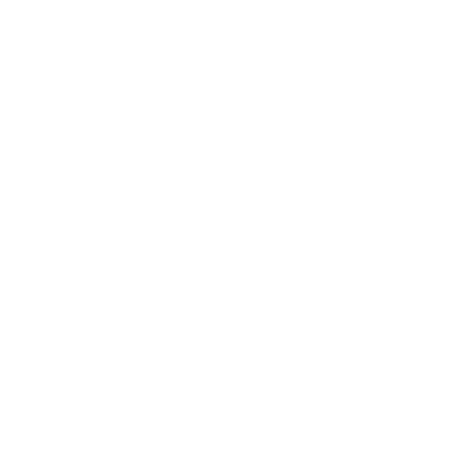

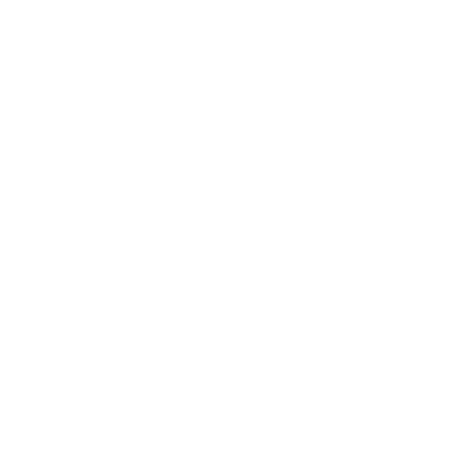

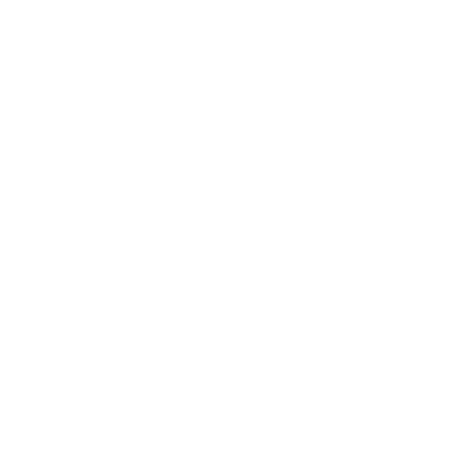

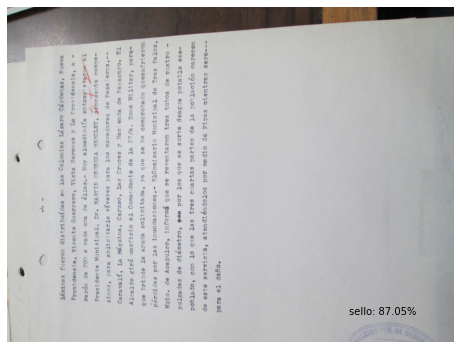

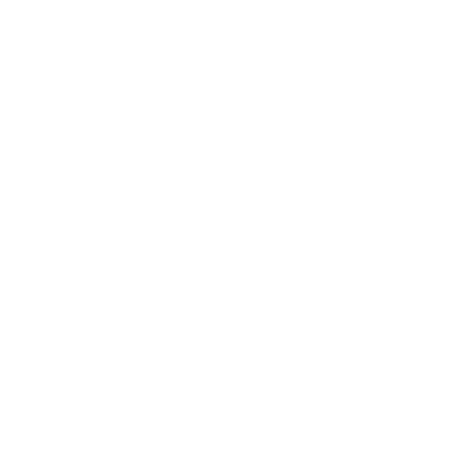

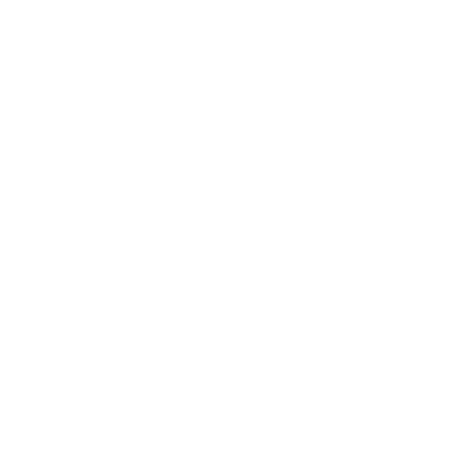

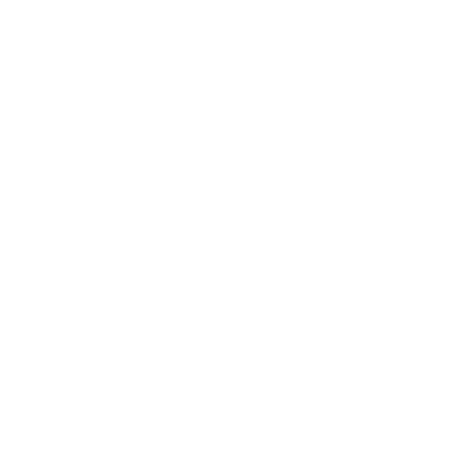

In [39]:
# Now there is a trained endpoint that can be used to make a prediction
from matplotlib import pyplot as plt
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import os
from os import scandir, getcwd
%matplotlib inline
# Open the sample image and get back the prediction results.


listawidth=[]
listaheight=[]
listaxmin=[]
listaymin=[]
listaxmax=[]
listaymax=[]
listanames=[]
listaetiqueta=[]
for img in lista:
    test_img_file = os.path.join ("test", img)
    test_img = Image.open(test_img_file)

    test_img_h, test_img_w, test_img_ch = np.array(test_img).shape



    with open(test_img_file, mode="rb") as test_data:
        results = predictor.detect_image("77d5d244-999b-4713-9ce2-a04ba8e410d7", "Iteration2", test_data)


    # Create a figure to display the results
    fig = plt.figure(figsize=(8, 8))
    plt.axis('off')

    # Display the image with boxes around each detected object
    draw = ImageDraw.Draw(test_img)
    lineWidth = int(np.array(test_img).shape[1]/100)

    # Display the results.    
    for prediction in results.predictions:
        if (prediction.probability*100) > 80:

            left = prediction.bounding_box.left * test_img_w 
            top = prediction.bounding_box.top * test_img_h 
            height = prediction.bounding_box.height * test_img_h
            width =  prediction.bounding_box.width * test_img_w
            points = ((left,top), (left+width,top), (left+width,top+height), (left,top+height),(left,top))
            listanames.append(os.path.basename(img))
            listawidth.append(test_img_w)
            listaheight.append(test_img_h)
            listaxmin.append(left)
            listaymin.append(top)
            listaxmax.append(left+width)
            listaymax.append(top+height)
            listaetiqueta.append(prediction.tag_name)
            plt.annotate(prediction.tag_name + ": {0:.2f}%".format(prediction.probability * 100),(left,top))
            print(prediction.tag_name + ": {0:.2f}%".format(prediction.probability * 100))
            print(points)
            plt.imshow(test_img)
    #print("\t" + prediction.tag_name + ": {0:.2f}% bbox.left = {1:.2f}, bbox.top = {2:.2f}, bbox.bottom = {2:.2f}, bbox.width = {3:.2f}, bbox.height = {4:.2f}".format(prediction.probability * 100, prediction.bounding_box.left, prediction.bounding_box.top, prediction.bounding_box.width, prediction.bounding_box.height))